In [0]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T 
# import cv2
# cv2.ocl.setUseOpenCL(False)

In [0]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [3]:
from google.colab import drive
import sys

#Mount your Google drive to the VM
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/Shared drive/ECE4179 PROJECT")

#set a root path variable to use
ROOT = "/content/gdrive/Shared drives/ECE4179 PROJECT"
PATH = ROOT + "/pong_dict_2.pt"

KeyboardInterrupt: ignored

In [0]:
# Action values to send to gym environment to move paddle up/down
UP_ACTION = 2
DOWN_ACTION = 3
# Mapping from action values to outputs from the policy network
action_dict = [UP_ACTION,DOWN_ACTION]


In [0]:
def cal_size2fcl(input_size2, kernel, stride):
  
    conv_out_size = (input_size2 - kernel + 1 -1)/stride + 1
    return int(conv_out_size)

In [0]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width): #greyscale image
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride = 4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride = 2)
#         self.maxpool = nn.MaxPool2d(2,stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride = 1)
      
        conv1_size = cal_size2fcl(84,8,4)
        conv2_size = cal_size2fcl(conv1_size,4,2)
        conv3_size = cal_size2fcl(conv2_size,3,1)
        
        
        self.fc1 = nn.Linear(in_features=(conv2_size**2)*64, out_features=512)   
        self.out = nn.Linear(in_features=512, out_features=2)
        
    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.relu(self.conv2(t))
#         t = F.relu(self.conv3(t))
      
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = self.out(t)
        return t
  

    
    

In [9]:
conv1_size = cal_size2fcl(80,8,4)
conv2_size = cal_size2fcl(conv1_size,4,2)
conv2_size**2*32
1152 

1152

In [0]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [0]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
            self.push_count += 1

    def sample(self, batch_size):
            return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
            return len(self.memory) >= batch_size

In [0]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

In [0]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
           
            return torch.tensor([random.randrange(self.num_actions)], device=self.device) # explore      
        else:
            with torch.no_grad():
                return torch.tensor([policy_net(state).argmax(dim=1).item()], device=self.device) # exploit            

In [0]:
class PongEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('PongDeterministic-v4').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close()
    
    def render(self, mode='RGB'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action_dict[action])
        return torch.tensor([reward], device=self.device)
      
    def take_random_action(self):
        action = self.env.action_space.sample()
        _, reward, self.done, _ = self.env.step(action)
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen = screen[0, 36:194, 15:144] #remove C and crop H and W
#         screen = screen[:, ::2, ::2]
        screen[screen == 144] = 0  # erase background (background type 1)
        screen[screen == 109] = 0  # erase background (background type 2)
        
        screen[screen != 0] = 255  
        return screen

    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
#         screen = np.ascontiguousarray(screen, dtype=np.uint8)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
#              ,T.Grayscale()
              ,T.Resize((84,84))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a channel dimension (BCHW)

In [0]:
def plot(frame_idx, rewards, losses):
    plt.clf()
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episode %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [0]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [0]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

In [0]:
batch_size = 32
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.0001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

em = PongEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, 2, device)
memory = ReplayMemory(memory_size)

policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.eval()
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()
Loss_list = []
Reward_list = []
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

episode_durations = []
start_episode = 0

In [19]:
checkpoint = torch.load(PATH)

policy_net.load_state_dict(checkpoint['policy_state_dict'])
target_net.load_state_dict(checkpoint['target_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_episode = checkpoint['episode']
# memory = checkpoint['memory']
# agent = checkpoint['agent']
Loss_list = checkpoint['losses']
Reward_list = checkpoint['rewards']
agent.current_step = checkpoint['agent_current_step']

NameError: ignored

###TEST

Text(0.5, 1.0, 'Processed screen example')

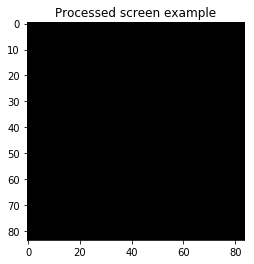

In [20]:
em.take_random_action()
screen = em.get_state()
screen.shape

plt.imshow(screen.detach().cpu().squeeze(0).squeeze(0), interpolation='none', cmap='gray')
plt.title('Processed screen example')



In [21]:
np.amax(screen.detach().cpu().numpy())
screen

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

In [0]:
env = gym.make('PongDeterministic-v4').unwrapped

In [23]:
action = env.action_space.sample()
_, reward, _, _ = env.step(action)
screen = env.render('rgb_array').transpose((2, 0, 1))
screen = screen[0, 36:194, 15:144] #remove C and crop H and W
#         screen = screen[:, ::2, ::2]
screen[screen == 144] = 0  # erase background (background type 1)
screen[screen == 109] = 0  # erase background (background type 2)
        
screen[screen != 0] = 255 
# find_len(screen.flatten())
screen
# plt.imshow(screen)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [0]:
screen = np.ascontiguousarray(screen, dtype=np.float32)/255
screen = torch.from_numpy(screen)

screen.shape

In [0]:
def find_len(list1): 
    length = len(list1) 
    list1.sort() 
    print("Largest element is:", list1[length-1]) 
    print("Smallest element is:", list1[0]) 
    print("Second Largest element is:", list1[length-2]) 
    print("Second Smallest element is:", list1[1]) 
  

In [0]:
resize = T.Compose([
            T.ToPILImage()
#                ,T.Grayscale()
              ,T.Resize((84,84))
            ,T.ToTensor()
        ])
find_len(resize(screen).numpy().flatten())
screen.shape

###TEST END


## START TRAIN


In [0]:
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    round_n = 1
    episode_reward_sum = 0
    step_n = 0
    

    while True:
        action = agent.select_action(state, policy_net)
        
        reward = em.take_action(action.item())
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        step_n += 1
        total_rewards += reward.item()
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            current_q_values = policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
#             current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            

#             loss = F.smooth_l1_loss(current_q_values, target_q_values.unsqueeze(1))  #Huber Loss
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            Loss_list.append(loss.item())
            
        if reward == -1:
            print("Round %d: %d time steps; lost..." % (round_n, step_n))
        elif reward == +1:
            print("Round %d: %d time steps; won!" % (round_n, step_n))
        if reward != 0:
            round_n += 1
            step_n = 0
        
        
        
        if em.done:
            print("Episode %d finished after %d rounds and %d rewards" % (episode + start_episode, round_n-1, total_rewards)) 
            Reward_list.append(total_rewards)
            total_rewards = 0;
            break
            
            
    if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
#             plt.plot(Loss_list)

    if(episode%50 == 0):
            torch.save({
                        'episode': episode,
                        'policy_state_dict':policy_net.state_dict(),
                        'target_state_dict':target_net.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
#                         'memory': memory,
                        'losses':Loss_list,
                        'rewards':Reward_list,
                        'agent_current_step':agent.current_step
                        }, PATH)
            plot(episode, Reward_list, Loss_list)
  
em.close()

In [0]:
state, action, next_state, reward

In [0]:
plt.plot(Loss_list)

In [0]:
plt.plot(Reward_list)